# Support Vector Machine (SVM)

In [1]:
#%% Instalar os pacotes necessários

# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install scipy
# !pip install openpyxl

In [147]:
#%% Importando os pacotes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

In [18]:
#%% Carregando o banco de dados

base_dados = pd.read_excel('dados_churn.xlsx')

In [19]:
base_dados.head(5)

,idade,sexo,cidade,categoria_plano,acessos_mes,valor_medio_transacao,reclamacao,churn
0,56,masculino,interior,basico,18,619.19,sim,1
1,23,feminino,interior,ouro,4,5334.66,nao,0
2,23,feminino,capital,basico,20,2326.62,sim,1
3,47,feminino,interior,sem,17,2344.58,sim,1
4,24,feminino,interior,sem,19,4456.50,sim,0


- Target: churn -> 1: deixou de ser cliente; 0 continua cliente

## Estatísticas descritivas

In [20]:
# Variáveis métricas
base_dados[['idade', 'acessos_mes', 'valor_medio_transacao']].describe()

,idade,acessos_mes,valor_medio_transacao
count,5390.000000,5390.000000,5390.000000
mean,41.192208,12.766605,2857.860443
std,13.481690,5.553906,1847.691791
min,18.000000,1.000000,80.050000
25%,30.000000,9.000000,1412.575000
50%,41.000000,13.000000,2700.805000
75%,53.000000,17.000000,4025.035000
max,64.000000,26.000000,9974.260000


In [8]:
# Variáveis categóricas
base_dados['churn'].value_counts()

churn
0    2698
1    2692
Name: count, dtype: int64

In [9]:
base_dados['sexo'].value_counts()

sexo
feminino     2863
masculino    2527
Name: count, dtype: int64

In [10]:
base_dados['cidade'].value_counts()

cidade
interior    3207
capital     2183
Name: count, dtype: int64

In [11]:
base_dados['categoria_plano'].value_counts()

categoria_plano
sem         1281
basico      1254
ouro        1140
prata        987
platinum     728
Name: count, dtype: int64

In [12]:
base_dados['reclamacao'].value_counts()

reclamacao
nao    2722
sim    2668
Name: count, dtype: int64

In [21]:
dados = pd.get_dummies(base_dados, 
                       columns=['sexo',
                                'cidade',
                                'categoria_plano',
                                'reclamacao'],
                        drop_first=False,
                        dtype='float')

In [22]:
dados.head(5)

,idade,acessos_mes,valor_medio_transacao,churn,sexo_feminino,sexo_masculino,cidade_capital,cidade_interior,categoria_plano_basico,categoria_plano_ouro,categoria_plano_platinum,categoria_plano_prata,categoria_plano_sem,reclamacao_nao,reclamacao_sim
0,56,18,619.19,1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,23,4,5334.66,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,23,20,2326.62,1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,47,17,2344.58,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,24,19,4456.50,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### Separação das bases de treino e teste

In [23]:
# Separando as variáveis Y e X | podemos retirar as colunas descritas já que são valores X/Y
X = dados.drop(columns=['churn', 'sexo_feminino', 'cidade_interior', 'reclamacao_nao'])
y = dados['churn']

In [24]:
# Gerando os conjuntos de treinamento e testes (70% treino e 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=100)

#### Padronização das variáveis métricas

In [25]:
# Vamos armazenar as informações de média e desvio padrão para previsões
media_idade, dp_idade = (X_train['idade'].mean(), X_train['idade'].std(ddof=1))

In [26]:
media_acessos, dp_acessos = (X_train['acessos_mes'].mean(), X_train['acessos_mes'].std(ddof=1))

In [27]:
media_valor, dp_valor = (X_train['valor_medio_transacao'].mean(), X_train['valor_medio_transacao'].std(ddof=1))

In [28]:
# padronização dos dados no banco de dados de treino
X_train['idade'] = stats.zscore(X_train['idade'], ddof=1)
X_train['acessos_mes'] = stats.zscore(X_train['acessos_mes'], ddof=1)
X_train['valor_medio_transacao'] = stats.zscore(X_train['valor_medio_transacao'], ddof=1)

In [29]:
# padronização dos dados no banco de dados de teste
X_test['idade'] = stats.zscore(X_test['idade'], ddof=1)
X_test['acessos_mes'] = stats.zscore(X_test['acessos_mes'], ddof=1)
X_test['valor_medio_transacao'] = stats.zscore(X_test['valor_medio_transacao'], ddof=1)

In [32]:
X_train.sample(3)

,idade,acessos_mes,valor_medio_transacao,sexo_masculino,cidade_capital,categoria_plano_basico,categoria_plano_ouro,categoria_plano_platinum,categoria_plano_prata,categoria_plano_sem,reclamacao_sim
3607,0.494180,0.405062,-0.499286,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4857,-0.995599,1.125174,0.674726,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3138,-0.623154,-0.135021,-1.456778,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [33]:
X_test.sample(3)

,idade,acessos_mes,valor_medio_transacao,sexo_masculino,cidade_capital,categoria_plano_basico,categoria_plano_ouro,categoria_plano_platinum,categoria_plano_prata,categoria_plano_sem,reclamacao_sim
4807,-0.620703,1.470781,0.599931,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1676,1.059213,-0.690285,0.193209,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
789,0.913133,-0.510196,0.665997,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Estimando o modelo SVM (Linear)

In [36]:
svm_linear = SVC(kernel='linear', C=0.1)
svm_linear

SVC(C=0.1, kernel='linear')

In [37]:
svm_linear.fit(X_train, y_train)

SVC(C=0.1, kernel='linear')

In [38]:
# Base de dados de treinamento
pred_linear_train = svm_linear.predict(X_train)

In [39]:
# Base de dados de teste
pred_linear_test = svm_linear.predict(X_test)

- Análise pela matriz de confusão (base de treino)

In [41]:
cm_linear_train = confusion_matrix(pred_linear_train, y_train)

In [48]:
cm_train_disp_linear = ConfusionMatrixDisplay(cm_linear_train)

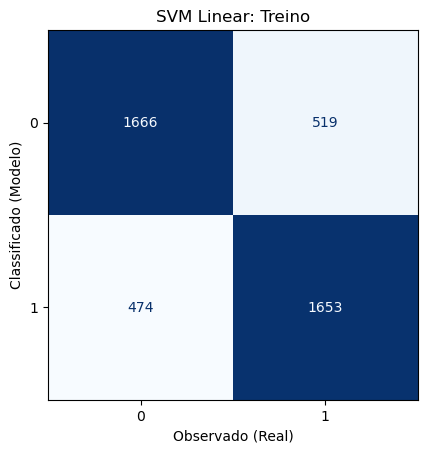

In [50]:
plt.rcParams['figure.dpi'] = 100
cm_train_disp_linear.plot(colorbar=False, cmap='Blues')
plt.title('SVM Linear: Treino')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

In [51]:
acc_linear_train = accuracy_score(y_train, pred_linear_train)

In [52]:
sens_linear_train = recall_score(y_train, pred_linear_train, pos_label=1)

In [53]:
espec_linear_train = recall_score(y_train, pred_linear_train, pos_label=0)

In [54]:
prec_linear_train = precision_score(y_train, pred_linear_train)

In [55]:
print("Avaliação do SVM Linear (Base de Treino)")
print(f"Acurácia: {acc_linear_train:.1%}")
print(f"Sensibilidade: {sens_linear_train:.1%}")
print(f"Especificidade: {espec_linear_train:.1%}")
print(f"Precision: {prec_linear_train:.1%}")

Avaliação do SVM Linear (Base de Treino)
Acurácia: 77.0%
Sensibilidade: 76.1%
Especificidade: 77.9%
Precision: 77.7%


In [56]:
#%% Análise pela matriz de confusão (base de teste)

cm_linear_test = confusion_matrix(pred_linear_test, y_test)

In [57]:
cm_test_disp_linear = ConfusionMatrixDisplay(cm_linear_test)

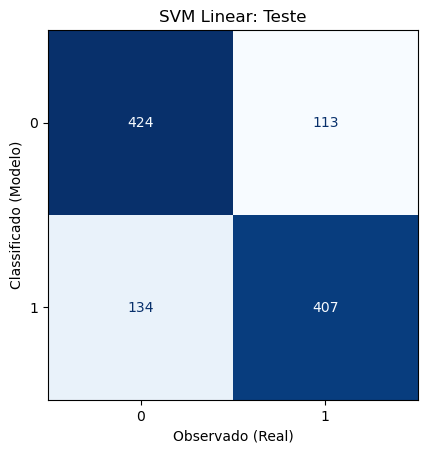

In [59]:
plt.rcParams['figure.dpi'] = 100
cm_test_disp_linear.plot(colorbar=False, cmap='Blues')
plt.title('SVM Linear: Teste')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

In [60]:
acc_linear_test = accuracy_score(y_test, pred_linear_test)

In [61]:
sens_linear_test = recall_score(y_test, pred_linear_test, pos_label=1)

In [62]:
espec_linear_test = recall_score(y_test, pred_linear_test, pos_label=0)

In [63]:
prec_linear_test = precision_score(y_test, pred_linear_test)

In [64]:
print("Avaliação do SVM Linear (Base de Teste)")
print(f"Acurácia: {acc_linear_test:.1%}")
print(f"Sensibilidade: {sens_linear_test:.1%}")
print(f"Especificidade: {espec_linear_test:.1%}")
print(f"Precision: {prec_linear_test:.1%}")

Avaliação do SVM Linear (Base de Teste)
Acurácia: 77.1%
Sensibilidade: 78.3%
Especificidade: 76.0%
Precision: 75.2%


- Estimando o modelo SVM (Polinomial)

In [70]:
svm_pol = SVC(kernel='poly', degree=2, coef0=0, C=0.1)
svm_pol

SVC(C=0.1, coef0=0, degree=2, kernel='poly')

In [71]:
svm_pol.fit(X_train, y_train)

SVC(C=0.1, coef0=0, degree=2, kernel='poly')

In [72]:
# Base de dados de treinamento
pred_pol_train = svm_pol.predict(X_train)

In [73]:
# Base de dados de teste
pred_pol_test = svm_pol.predict(X_test)

In [74]:
#%% Análise pela matriz de confusão (base de treino)

cm_pol_train = confusion_matrix(pred_pol_train, y_train)

In [75]:
cm_train_disp_pol = ConfusionMatrixDisplay(cm_pol_train)

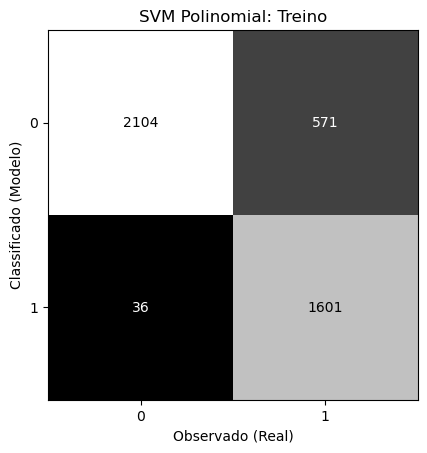

In [76]:
plt.rcParams['figure.dpi'] = 100
cm_train_disp_pol.plot(colorbar=False, cmap='gray')
plt.title('SVM Polinomial: Treino')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

In [77]:
acc_pol_train = accuracy_score(y_train, pred_pol_train)

In [78]:
sens_pol_train = recall_score(y_train, pred_pol_train, pos_label=1)

In [79]:
espec_pol_train = recall_score(y_train, pred_pol_train, pos_label=0)

In [80]:
prec_pol_train = precision_score(y_train, pred_pol_train)

In [81]:
print("Avaliação do SVM Polinomial (Base de Treino)")
print(f"Acurácia: {acc_pol_train:.1%}")
print(f"Sensibilidade: {sens_pol_train:.1%}")
print(f"Especificidade: {espec_pol_train:.1%}")
print(f"Precision: {prec_pol_train:.1%}")

Avaliação do SVM Polinomial (Base de Treino)
Acurácia: 85.9%
Sensibilidade: 73.7%
Especificidade: 98.3%
Precision: 97.8%


In [82]:
#%% Análise pela matriz de confusão (base de teste)

cm_pol_test = confusion_matrix(pred_pol_test, y_test)

In [83]:
cm_test_disp_pol = ConfusionMatrixDisplay(cm_pol_test)

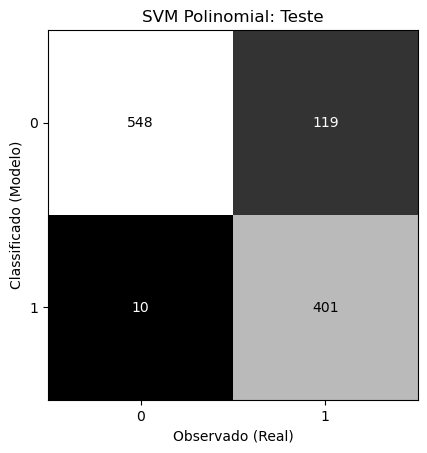

In [84]:
plt.rcParams['figure.dpi'] = 100
cm_test_disp_pol.plot(colorbar=False, cmap='gray')
plt.title('SVM Polinomial: Teste')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

In [86]:
acc_pol_test = accuracy_score(y_test, pred_pol_test)

In [87]:
sens_pol_test = recall_score(y_test, pred_pol_test, pos_label=1)

In [88]:
espec_pol_test = recall_score(y_test, pred_pol_test, pos_label=0)

In [89]:
prec_pol_test = precision_score(y_test, pred_pol_test)

In [90]:
print("Avaliação do SVM Polinomial (Base de Teste)")
print(f"Acurácia: {acc_pol_test:.1%}")
print(f"Sensibilidade: {sens_pol_test:.1%}")
print(f"Especificidade: {espec_pol_test:.1%}")
print(f"Precision: {prec_pol_test:.1%}")

Avaliação do SVM Polinomial (Base de Teste)
Acurácia: 88.0%
Sensibilidade: 77.1%
Especificidade: 98.2%
Precision: 97.6%


- Estimando o modelo SVM (RBF)

In [95]:
svm_rbf = SVC(kernel='rbf', C=0.1, gamma=1)
svm_rbf

SVC(C=0.1, gamma=1)

In [96]:
svm_rbf.fit(X_train, y_train)

SVC(C=0.1, gamma=1)

- Categorias preditas pelo modelo RBF

In [97]:
# Base de dados de treinamento
pred_rbf_train = svm_rbf.predict(X_train)

In [98]:
# Base de dados de teste
pred_rbf_test = svm_rbf.predict(X_test)

In [99]:
#%% Análise pela matriz de confusão (base de treino)

cm_rbf_train = confusion_matrix(pred_rbf_train, y_train)
cm_train_disp_rbf = ConfusionMatrixDisplay(cm_rbf_train)

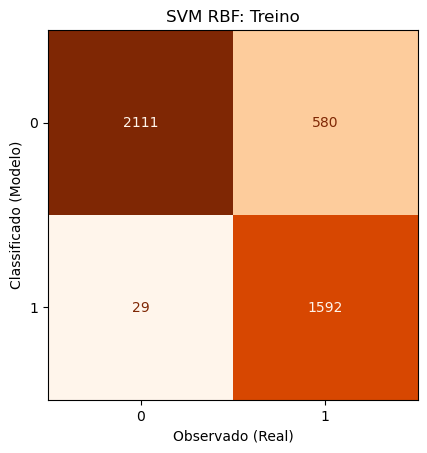

In [101]:
plt.rcParams['figure.dpi'] = 100
cm_train_disp_rbf.plot(colorbar=False, cmap='Oranges')
plt.title('SVM RBF: Treino')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

In [102]:
acc_rbf_train = accuracy_score(y_train, pred_rbf_train)

In [103]:
sens_rbf_train = recall_score(y_train, pred_rbf_train, pos_label=1)

In [104]:
espec_rbf_train = recall_score(y_train, pred_rbf_train, pos_label=0)

In [105]:
prec_rbf_train = precision_score(y_train, pred_rbf_train)

In [106]:
print("Avaliação do SVM RBF (Base de Treino)")
print(f"Acurácia: {acc_rbf_train:.1%}")
print(f"Sensibilidade: {sens_rbf_train:.1%}")
print(f"Especificidade: {espec_rbf_train:.1%}")
print(f"Precision: {prec_rbf_train:.1%}")

Avaliação do SVM RBF (Base de Treino)
Acurácia: 85.9%
Sensibilidade: 73.3%
Especificidade: 98.6%
Precision: 98.2%


In [107]:
#%% Análise pela matriz de confusão (base de teste)

cm_rbf_test = confusion_matrix(pred_rbf_test, y_test)
cm_test_disp_rbf = ConfusionMatrixDisplay(cm_rbf_test)

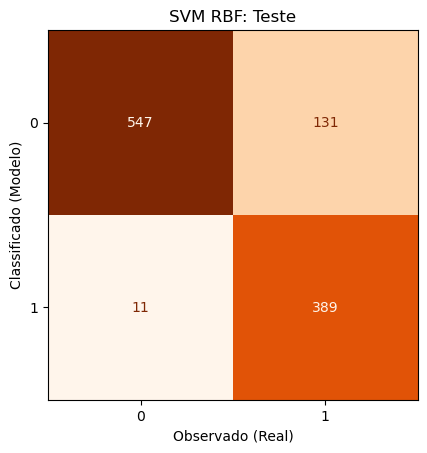

In [109]:
plt.rcParams['figure.dpi'] = 100
cm_test_disp_rbf.plot(colorbar=False, cmap='Oranges')
plt.title('SVM RBF: Teste')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

In [110]:
acc_rbf_test = accuracy_score(y_test, pred_rbf_test)

In [111]:
sens_rbf_test = recall_score(y_test, pred_rbf_test, pos_label=1)

In [112]:
espec_rbf_test = recall_score(y_test, pred_rbf_test, pos_label=0)

In [113]:
prec_rbf_test = precision_score(y_test, pred_rbf_test)

In [114]:
print("Avaliação do SVM RBF (Base de Teste)")
print(f"Acurácia: {acc_rbf_test:.1%}")
print(f"Sensibilidade: {sens_rbf_test:.1%}")
print(f"Especificidade: {espec_rbf_test:.1%}")
print(f"Precision: {prec_rbf_test:.1%}")

Avaliação do SVM RBF (Base de Teste)
Acurácia: 86.8%
Sensibilidade: 74.8%
Especificidade: 98.0%
Precision: 97.2%


- Grid Search

In [115]:
# Especificar a lista de hiperparâmetros
param_grid = [
  {'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['linear']},
  {'C': [0.1, 0.5, 1, 5, 10], 'degree': [2, 3], 'coef0': [0, 1], 'kernel': ['poly']},
  {'C': [0.1, 0.5, 1, 5, 10], 'gamma': [0.1, 1, 10, 100], 'kernel': ['rbf']},
]

In [116]:
# Identificar o algoritmo em uso
svm_grid = SVC()

In [117]:
# Treinar os modelos para o grid search
model_grid = GridSearchCV(estimator = svm_grid, 
                          param_grid = param_grid,
                          scoring='accuracy',
                          cv=5,
                          verbose=2)

model_grid.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.5, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.5, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.5, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.5, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.5, kernel=linear; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, 

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['linear']},
                         {'C': [0.1, 0.5, 1, 5, 10], 'coef0': [0, 1],
                          'degree': [2, 3], 'kernel': ['poly']},
                         {'C': [0.1, 0.5, 1, 5, 10], 'gamma': [0.1, 1, 10, 100],
                          'kernel': ['rbf']}],
             scoring='accuracy', verbose=2)

In [118]:
# Verificando os melhores parâmetros obtidos
print(model_grid.best_params_)

{'C': 1, 'coef0': 1, 'degree': 3, 'kernel': 'poly'}


In [119]:
# Gerando o modelo com os melhores hiperparâmetros
svm_best = model_grid.best_estimator_

In [120]:
# Valores preditos nas bases de treino e teste
pred_grid_train = svm_best.predict(X_train)
pred_grid_test = svm_best.predict(X_test)

In [121]:
#%% Análise pela matriz de confusão (base de treino)

cm_grid_train = confusion_matrix(pred_grid_train, y_train)
cm_train_disp_grid = ConfusionMatrixDisplay(cm_grid_train)

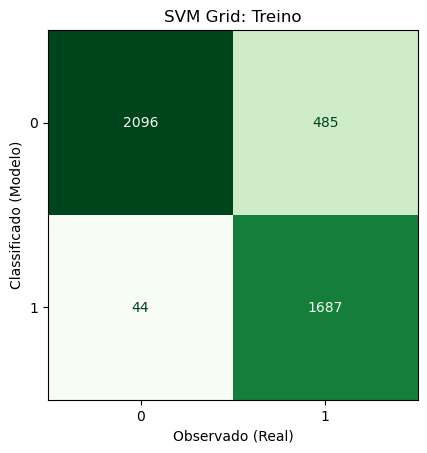

In [123]:
plt.rcParams['figure.dpi'] = 100
cm_train_disp_grid.plot(colorbar=False, cmap='Greens')
plt.title('SVM Grid: Treino')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

In [124]:
acc_grid_train = accuracy_score(y_train, pred_grid_train)

In [125]:
sens_grid_train = recall_score(y_train, pred_grid_train, pos_label=1)

In [126]:
espec_grid_train = recall_score(y_train, pred_grid_train, pos_label=0)

In [127]:
prec_grid_train = precision_score(y_train, pred_grid_train)

In [128]:
print("Avaliação do SVM Grid (Base de Treino)")
print(f"Acurácia: {acc_grid_train:.1%}")
print(f"Sensibilidade: {sens_grid_train:.1%}")
print(f"Especificidade: {espec_grid_train:.1%}")
print(f"Precision: {prec_grid_train:.1%}")

Avaliação do SVM Grid (Base de Treino)
Acurácia: 87.7%
Sensibilidade: 77.7%
Especificidade: 97.9%
Precision: 97.5%


In [129]:
#%% Análise pela matriz de confusão (base de teste)

cm_grid_test = confusion_matrix(pred_grid_test, y_test)
cm_test_disp_grid = ConfusionMatrixDisplay(cm_grid_test)

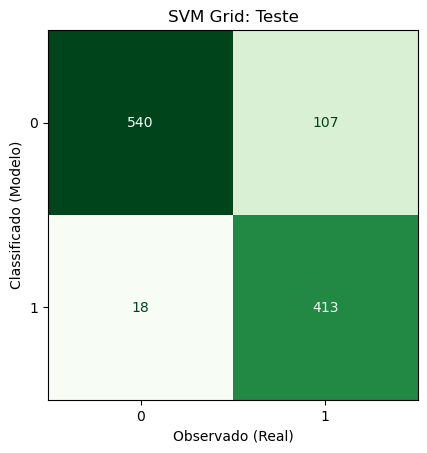

In [130]:
plt.rcParams['figure.dpi'] = 100
cm_test_disp_grid.plot(colorbar=False, cmap='Greens')
plt.title('SVM Grid: Teste')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

In [131]:
acc_grid_test = accuracy_score(y_test, pred_grid_test)

In [132]:
sens_grid_test = recall_score(y_test, pred_grid_test, pos_label=1)

In [133]:
espec_grid_test = recall_score(y_test, pred_grid_test, pos_label=0)

In [134]:
prec_grid_test = precision_score(y_test, pred_grid_test)

In [135]:
print("Avaliação do SVM Grid (Base de Teste)")
print(f"Acurácia: {acc_grid_test:.1%}")
print(f"Sensibilidade: {sens_grid_test:.1%}")
print(f"Especificidade: {espec_grid_test:.1%}")
print(f"Precision: {prec_grid_test:.1%}")

Avaliação do SVM Grid (Base de Teste)
Acurácia: 88.4%
Sensibilidade: 79.4%
Especificidade: 96.8%
Precision: 95.8%


In [136]:
#%% Importância das variáveis preditoras no modelo

result = permutation_importance(svm_best, X_test, y_test, 
                                n_repeats=10, 
                                scoring='accuracy',
                                random_state=100)

In [137]:
sort_importances = result.importances_mean.argsort()

In [138]:
importances = pd.DataFrame(result.importances[sort_importances].T,
                           columns=X_test.columns[sort_importances])

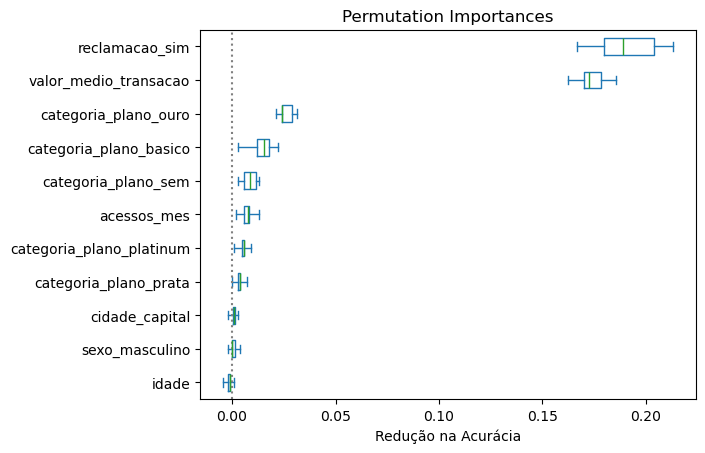

In [139]:
# Plotar no gráfico
plt.rcParams['figure.dpi'] = 100
importances.plot.box(vert=False, whis=10)
plt.title('Permutation Importances')
plt.xlabel('Redução na Acurácia')
plt.axvline(x=0, color='gray', linestyle=':')
plt.show()

## Realizando previsões para novas observações

- Aplicação de um novo cliente

In [ ]:
# Note que as variáveis métricas são padronizadas
novo_cliente = pd.DataFrame({'idade': [((50-media_idade)/dp_idade)],
                             'acessos_mes': [((10-media_acessos)/dp_acessos)],
                             'valor_medio_transacao': [((3500-media_valor)/dp_valor)],
                             'sexo_masculino': [0],
                             'cidade_capital': [1],
                             'categoria_plano_basico': [1],
                             'categoria_plano_ouro': [0],
                             'categoria_plano_platinum': [0],
                             'categoria_plano_prata': [0],
                             'categoria_plano_sem': [0],
                             'reclamacao_sim': [1]})

In [ ]:
# Previsão do modelo final
svm_best.predict(novo_cliente)

In [141]:
base_dados.head(3)

,idade,sexo,cidade,categoria_plano,acessos_mes,valor_medio_transacao,reclamacao,churn
0,56,masculino,interior,basico,18,619.19,sim,1
1,23,feminino,interior,ouro,4,5334.66,nao,0
2,23,feminino,capital,basico,20,2326.62,sim,1


In [144]:
base_dados['acessos_mes'].max()

np.int64(26)

In [145]:
base_dados['acessos_mes'].min()

np.int64(1)

- Aplicação em uma nova série de clientes

In [175]:
novos_dados_churn = pd.read_csv('novos_dados_churn_teste')

In [176]:
novos_dados_churn.head()

,idade,acessos_mes,valor_medio_transacao,sexo_masculino,cidade_capital,categoria_plano_basico,categoria_plano_ouro,categoria_plano_platinum,categoria_plano_prata,categoria_plano_sem,reclamacao_sim
0,33,8,638.08,0,1,0,1,0,0,0,1
1,23,9,326.73,0,0,0,0,0,0,1,0
2,23,10,932.17,1,0,0,0,0,1,0,1
3,48,9,432.88,0,1,0,1,0,0,0,0
4,43,11,1247.02,1,1,0,0,0,1,0,1


In [177]:
novos_dados_churn['idade'] = (novos_dados_churn['idade']-media_idade)/dp_idade

In [178]:
novos_dados_churn['acessos_mes'] = (novos_dados_churn['acessos_mes']-media_acessos)/dp_acessos

In [179]:
novos_dados_churn['valor_medio_transacao'] = (novos_dados_churn['valor_medio_transacao']-media_valor)/dp_valor

In [180]:
previsoes = svm_best.predict(novos_dados_churn)

In [181]:
previsoes

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [182]:
novos_dados_churn['previsao_svm'] = previsoes

In [183]:
novos_dados_churn

,idade,acessos_mes,valor_medio_transacao,sexo_masculino,cidade_capital,categoria_plano_basico,categoria_plano_ouro,categoria_plano_platinum,categoria_plano_prata,categoria_plano_sem,reclamacao_sim,previsao_svm
0,-0.623154,-0.855132,-1.199969,0,1,0,1,0,0,0,1,1
1,-1.368043,-0.675104,-1.369023,0,0,0,0,0,0,1,0,1
2,-1.368043,-0.495076,-1.040286,1,0,0,0,0,1,0,1,1
3,0.494180,-0.675104,-1.311386,0,1,0,1,0,0,0,0,0
4,0.121736,-0.315049,-0.869332,1,1,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1.219066,-0.315049,-1.352625,0,0,0,1,0,0,0,1,1
96,0.866625,-0.135021,-1.071290,1,1,0,0,1,0,0,1,1
97,-0.548665,-1.035160,-1.433213,1,0,0,0,0,0,1,0,1
98,-0.176220,-0.675104,-1.085217,0,0,0,0,0,1,0,1,1


In [ ]:
#%% Fim!